In [30]:
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from tensorflow.keras import layers,Sequential,losses
plt.rcParams['font.size'] = 16
plt.rcParams['font.family'] = ['STKaiti']
plt.rcParams['axes.unicode_minus'] = False

In [31]:
dataset_path = keras.utils.get_file("auto-mpg.data",
"http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data")

column_names = ['MPG','Cylinders','Displacement','Horsepower','Weight',
'Acceleration', 'Model Year', 'Origin']

In [32]:
raw_dataset = pd.read_csv(dataset_path, names=column_names,
na_values = "?", comment='\t',
sep=" ", skipinitialspace=True)
dataset = raw_dataset.copy()

In [33]:
# 未删除前 398行
dataset.isna().sum
# 删除空白数据，变为 392行
dataset = dataset.dropna()

In [34]:
#未处理的origin未 1，2 ，3 
#分别代表 USA,Europe,Japan
origin = dataset.pop('Origin')
dataset['USA'] = (origin==1) * 1.0
dataset['Europe'] = (origin==2) * 1.0
dataset['Japan'] = (origin==3) * 1.0

In [35]:
# # 划分训练集
# 数据集按8：2的比例分割为训练集和测试集
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)
train_labels = train_dataset.pop('MPG')
test_labels = test_dataset.pop('MPG')

In [36]:
# 对数据标准化,统计各字段的均值，标准差
train_stats = train_dataset.describe()
train_stats = train_stats.transpose()

In [37]:
# 标准化数据
def norm(x):
    return (x - train_stats['mean']) / train_stats['std']
norm_train_data = norm(train_dataset)
norm_test_data = norm(test_dataset)

In [38]:
print(norm_train_data.shape,train_labels.shape)
print(norm_test_data.shape,test_labels.shape)

(314, 9) (314,)
(78, 9) (78,)


In [39]:
# 构件dataset对象
train_db = tf.data.Dataset.from_tensor_slices((norm_train_data.values, train_labels.values))
train_db = train_db.shuffle(100).batch(32)

In [40]:
# 自定义网络继承基类keras.Model
class Network(keras.Model):
    def __init__(self):
    # 对继承自父类的属性进行初始化，并且用父类的初始化方法初始化继承的属性。:
        super(Network,self).__init__()
        self.fc1 = layers.Dense(64, activation='relu')
        self.fc2 = layers.Dense(64, activation='relu')
        self.fc3 = layers.Dense(1)
    def call(self, inputs, training = None, mask = None):
        
        x = self.fc1(inputs)
        x = self.fc2(x)
        x = self.fc3(x)
        
        return x

In [41]:
# 实例化网络对象和创建优化器
model = Network()
# build 函数完成内部张量的创建，4 未任意设置的 batch数量，9 为特征长度
model.build(input_shape=(4, 9))
model.summary() #打印网络信息
# 优化器
optimizer = tf.keras.optimizers.RMSprop(0.001)


Model: "network_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              multiple                  640       
_________________________________________________________________
dense_7 (Dense)              multiple                  4160      
_________________________________________________________________
dense_8 (Dense)              multiple                  65        
Total params: 4,865
Trainable params: 4,865
Non-trainable params: 0
_________________________________________________________________


In [ ]:
train_mae_losses = []
test_mae_losses = []
# 网络训练
for epoch in range(200):
    # 注意是 enumerate 类型
    for step, (x,y) in enumerate(train_db):
        with tf.GradientTape() as tape:
            out = model(x)
            loss = tf.reduce_mean(losses.MSE(y,out))
            mae_loss = tf.reduce_mean(losses.MAE(y, out))

        if step % 50 == 0:
            print(epoch, step, float(loss))
        grads = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))
    train_mae_losses.append(float(mae_loss))
    out = model(tf.constant(norm_test_data.values))
    test_mae_losses.append(tf.reduce_mean(losses.MAE(test_labels,out)))

            

In [61]:
def plot(train_mae_losses, test_mae_losses):
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('MAE')
    # 数组元素，索引为横坐标
    plt.plot(train_mae_losses, label='Train')
    plt.plot(test_mae_losses, label='Test')
    plt.legend()
    plt.ylim([0,10])
    plt.legend()
    plt.show()

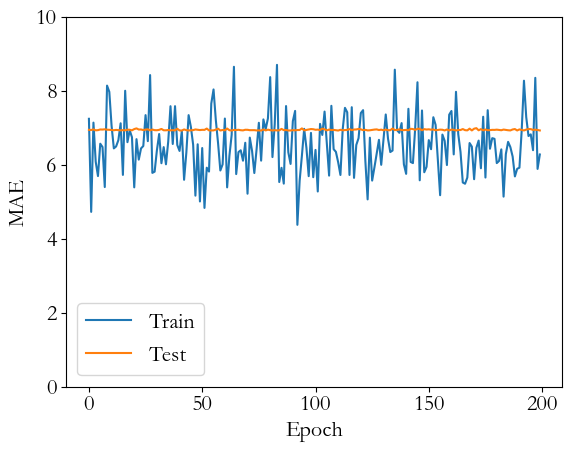

In [62]:
plot(train_mae_losses, test_mae_losses)